In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers,models
import pandas as pd
import os
import cv2

## Part 1: Data Preprocessing

### Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 設定資料路徑
# training data path
trcloudy='/content/drive/MyDrive/weather_image/train/cloudy/'
trrain='/content/drive/MyDrive/weather_image/train/rain/'
trshine='/content/drive/MyDrive/weather_image/train/shine/'
trsunrise='/content/drive/MyDrive/weather_image/train/sunrise/'
# testing data path
testpath='/content/drive/MyDrive/weather_image/test/'

In [4]:
# 顯示資料筆數
print('train cloudy length: ',len(os.listdir(trcloudy)))
print('train rain length: ',len(os.listdir(trrain)))
print('train shine length: ',len(os.listdir(trshine)))
print('train sunrise length: ',len(os.listdir(trsunrise)))
print('\n')
print('test data length: ',len(os.listdir(testpath)))

train cloudy length:  280
train rain length:  199
train shine length:  232
train sunrise length:  337


test data length:  75


### convert image data to numpy

In [5]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.5),
])

In [6]:
# convert the train data to numpy
tr_label=list()
tr_data=np.empty(shape=(2096,100,100,3))
x=0
for i in range(len(os.listdir(trcloudy))):
  f=os.listdir(trcloudy)[i]
  img=cv2.imread(trcloudy+f)
  img=cv2.resize(img,(100,100))
  img=img[:,:,::-1]/255
  tr_data[x]=img
  tr_label.append(0)
  x+=1
  tr_data[x]=data_augmentation(img)
  tr_label.append(0)
  x+=1
for i in range(len(os.listdir(trrain))):
  f=os.listdir(trrain)[i]
  img=cv2.imread(trrain+f)
  img=cv2.resize(img,(100,100))
  img=img[:,:,::-1]/255
  tr_data[x]=img
  tr_label.append(1)
  x+=1
  tr_data[x]=data_augmentation(img)
  tr_label.append(1)
  x+=1
for i in range(len(os.listdir(trshine))):
  f=os.listdir(trshine)[i]
  img=cv2.imread(trshine+f)
  img=cv2.resize(img,(100,100))
  img=img[:,:,::-1]/255
  tr_data[x]=img
  tr_label.append(2)
  x+=1
  tr_data[x]=data_augmentation(img)
  tr_label.append(2)
  x+=1
for i in range(len(os.listdir(trsunrise))):
  f=os.listdir(trsunrise)[i]
  img=cv2.imread(trsunrise+f)
  img=cv2.resize(img,(100,100))
  img=img[:,:,::-1]/255
  tr_data[x]=img
  tr_label.append(3)
  x+=1
  tr_data[x]=data_augmentation(img)
  tr_label.append(3)
  x+=1

tr_label=np.array(tr_label)

In [7]:
# convert the test data to numpy
te_filename=list()
te_data=np.empty(shape=(75,100,100,3))
for i in range(len(os.listdir(testpath))):
  f=os.listdir(testpath)[i]
  te_filename.append(f)
  img=cv2.imread(testpath+f)
  img=cv2.resize(img,(100,100))
  img=img[:,:,::-1]/255
  te_data[i]=img

In [8]:
# show data size
print('train data size:',tr_data.shape)
print('train label size:',len(tr_label))
print('test data size:',te_data.shape)

train data size: (2096, 100, 100, 3)
train label size: 2096
test data size: (75, 100, 100, 3)


### shuffle

In [9]:
# on-hot label
from tensorflow.keras.utils import to_categorical
tr_label=to_categorical(tr_label)
# 打亂資料順序
from sklearn.utils import shuffle
tr_data,tr_label=shuffle(tr_data,tr_label,random_state=0)

### train_validation data split

In [10]:
# train_validation data split
#val_data數量固定262個
train_data=tr_data[0:1834]
val_data=tr_data[1834:]
train_label=tr_label[0:1834]
val_label=tr_label[1834:]
print('train data size: ',train_data.shape)
print('validation data size: ',val_data.shape)
print('train label size: ',train_label.shape)
print('validation label size: ',val_label.shape)

train data size:  (1834, 100, 100, 3)
validation data size:  (262, 100, 100, 3)
train label size:  (1834, 4)
validation label size:  (262, 4)


## Part 2: Build a simple CNN

In [11]:
# define model
cnn=models.Sequential() # name the network
# feature extraction
cnn.add(layers.Conv2D(filters=32,kernel_size=(3,3), input_shape=(100,100,3),activation='relu',padding='same'))
cnn.add(layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'))
cnn.add(layers.MaxPooling2D(pool_size=(2,2),padding='same'))
cnn.add(layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
cnn.add(layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
cnn.add(layers.MaxPooling2D(pool_size=(2,2),padding='same'))
cnn.add(layers.Flatten())
cnn.add(layers.Dropout(0.5))
# neron network
cnn.add(layers.Dense(units=64,activation='relu'))
cnn.add(layers.Dense(units=32,activation='relu'))
cnn.add(layers.Dense(units=4,activation='softmax'))
# show the model structure
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                  

In [12]:
# comiple model
cnn.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")

In [14]:
#history = cnn.fit(train_data, train_label,batch_size=10 ,epochs=3,validation_split=0.3)
history = cnn.fit_generator(datagen.flow(train_data, train_label, batch_size=10), validation_data=(val_data, val_label), epochs=100)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


184/184 [==============================] - 14s 31ms/step - loss: 0.7753 - accuracy: 0.6483 - val_loss: 0.6508 - val_accuracy: 0.6908
Epoch 2/100
184/184 [==============================] - 5s 28ms/step - loss: 0.5356 - accuracy: 0.7748 - val_loss: 0.4893 - val_accuracy: 0.8244
Epoch 3/100
184/184 [==============================] - 5s 28ms/step - loss: 0.4997 - accuracy: 0.7814 - val_loss: 0.4660 - val_accuracy: 0.7786
Epoch 4/100
184/184 [==============================] - 5s 28ms/step - loss: 0.4969 - accuracy: 0.7966 - val_loss: 0.4183 - val_accuracy: 0.8015
Epoch 5/100
184/184 [==============================] - 5s 28ms/step - loss: 0.4899 - accuracy: 0.8064 - val_loss: 0.3669 - val_accuracy: 0.8244
Epoch 6/100
184/184 [==============================] - 5s 28ms/step - loss: 0.4585 - accuracy: 0.8113 - val_loss: 0.4528 - val_accuracy: 0.8130
Epoch 7/100
184/184 [==============================] - 5s 28ms/step - loss: 0.4376 - accuracy: 0.8277 - val_loss: 0.3601 - val_accuracy: 0.8626
Epo

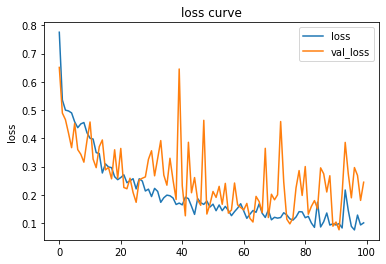

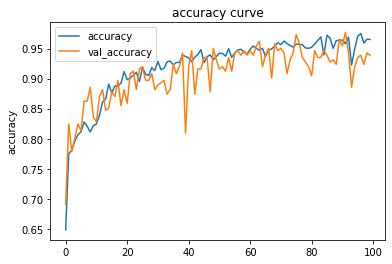

In [15]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('loss curve')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.title('accuracy curve')
plt.ylabel('accuracy')
plt.legend()
plt.show()

### Plot the confusion matrix

In [16]:
from sklearn.metrics import confusion_matrix
pre=cnn.predict(val_data)
pre=np.argmax(pre,axis=1)

9/9 [==============================] - 0s 11ms/step


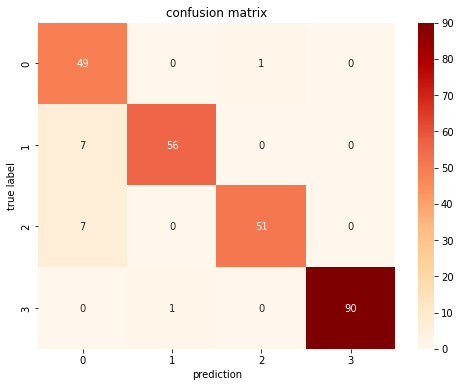

In [17]:
import seaborn as sn
cm=confusion_matrix(pre,np.argmax(val_label,axis=1))
fit=plt.figure(figsize=(8,6))
plt.title('confusion matrix')
sn.heatmap(cm,annot=True,cmap='OrRd',fmt='g')
plt.xlabel('prediction')
plt.ylabel('true label')
plt.show()

# Output the csv file

In [18]:
import pandas as pd

In [19]:
prediction=cnn.predict(te_data)
prediction=np.argmax(prediction,axis=1)
prediction

3/3 [==============================] - 0s 89ms/step


array([0, 2, 2, 3, 3, 1, 0, 1, 3, 2, 2, 2, 0, 2, 1, 3, 1, 0, 0, 3, 2, 1,
       2, 3, 0, 3, 0, 3, 3, 0, 2, 1, 0, 0, 1, 3, 0, 2, 2, 1, 3, 3, 1, 2,
       3, 0, 3, 2, 2, 3, 2, 0, 0, 1, 2, 0, 2, 3, 3, 0, 1, 0, 1, 3, 3, 2,
       3, 0, 1, 1, 0, 1, 3, 1, 3])

In [20]:
test_label=pd.DataFrame()
test_label['image_id']=te_filename
test_label['labels']=prediction
test_label=test_label.sort_values(by='image_id')
test_label.to_csv('/content/drive/MyDrive/weather_image/predict_label.csv',index=False) #結果轉csv檔

# Part3: Data augmentation

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.5),
])

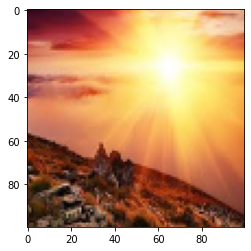

In [22]:
data=tr_data[1]
data=data_augmentation(data)
plt.imshow(data)